### 0.Imports

In [ ]:
!pip install load-dotenv
!pip install scikit-learn
!pip install pandas
!pip install requests
!pip install tqdm
!pip3 install ipywidgets #restart kernel after installation
!pip install matplotlib
!pip install seaborn

In [1]:
from pandas import read_csv, DataFrame, crosstab
import os
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import requests
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sn

### 1. Prepare Data & Prompts

#### 1.1 Read Data, filter columns and rename them

In [2]:
data= read_csv('cfpb_compliants.csv')
data=data[['narrative','product']]
data = data.rename(columns={'narrative': 'input', 'product' : 'output'})
data.head()


,input,output
0,currently hold one credit best buy visa paying...,credit_card
1,asked verification debt appeared credit report...,debt_collection
2,loan chase auto car accident car totaled insur...,mortgages_and_loans
3,pas due amount came denied income driven plan ...,mortgages_and_loans
4,attn collection dept submitting complaint refe...,credit_reporting


In [3]:
data.output.value_counts()

output
debt_collection        6642
credit_reporting       6000
mortgages_and_loans    5822
credit_card            5031
retail_banking         3863
Name: count, dtype: int64

##### Experiment: Filter to only work with 256 characters complaints

In [4]:
data_256_filter = data['input'].str.len() < 256
data_256 = data[data_256_filter]
len(data_256)

8071

In [5]:
data_256.output.value_counts()

output
debt_collection        2465
credit_reporting       2362
retail_banking         1187
credit_card            1066
mortgages_and_loans     991
Name: count, dtype: int64

#### 1.2 Create datasets for training and test

In [6]:
data_train, data_test, y_train, y_test = train_test_split(data_256['input'], 
                                                    data_256['output'],
                                                    test_size=0.3,
                                                    random_state=33, 
                                                    stratify=data_256['output'])
data_train = DataFrame(data_train)
data_test = DataFrame(data_test)

#### 1.3 Create training data file ( to be used thru the Tuning Studio UI )

In [7]:

data_train_and_labels = data_train.copy()
data_train_and_labels['output'] = y_train

data_train_and_labels[:2000].to_json('data/2000-compliants_classification_training_examples.json', orient ="records")


In [8]:
data_train_and_labels[:2000].output.value_counts()

output
credit_reporting       621
debt_collection        588
retail_banking         291
credit_card            260
mortgages_and_loans    240
Name: count, dtype: int64

#### 1.4. Create Data Test

##### Experiment: Same number of examples per class

In [8]:
data_train_sample = data_train_and_labels.groupby("output").sample(n=600, random_state=1)
data_train_sample['output'].value_counts()

output
credit_card            600
credit_reporting       600
debt_collection        600
mortgages_and_loans    600
retail_banking         600
Name: count, dtype: int64

In [9]:
data_train_sample.to_json('data/600c_compliants_classification_training_examples.json', orient ="records")

##### Select random 1000 examples


In [10]:
data_test_and_labels = data_test.copy()
data_test_and_labels['output'] = y_test

In [11]:
data_test_and_labels[:1000].to_json('data/testing_examples.json', orient ="records")

In [12]:
data_test_and_labels.output.value_counts()

output
debt_collection        740
credit_reporting       709
retail_banking         356
credit_card            320
mortgages_and_loans    297
Name: count, dtype: int64

#### Go to Tuning Studio

In [13]:
""" Classification output (verbalizer) :
classify { "credit_card", "debt_collection","mortgages_and_loans", "retail_banking","credit_reporting" } Input: {{input}} Output:
"""

#TODO : fine tuning by code

' Classification output (verbalizer) :\nclassify { "credit_card", "debt_collection","mortgages_and_loans", "retail_banking","credit_reporting" } Input: {{input}} Output:\n'

#### Prepare for Prompting

In [14]:
instruction="""Determine the class of product expressed in the sentence.
Use either 'credit_card', 'debt_collection','mortgages_and_loans','retail_banking', or 'credit_reporting'.

sentence: {sentence}

class: 
"""

In [15]:
parameters = {
         "decoding_method": "greedy",
         "random_seed": 33,
         "repetition_penalty":1,
         "min_new_tokens": 1,
         "max_new_tokens": 10
}

In [16]:
inputs_test = [{"input": text} for text in data_test_and_labels['input']]
y_test = data_test_and_labels['output']

### 2. Test Performance FLAN-T5 ( withouth prompt tuning)

#### 2.1 ZERO SHOT PROMTING APPROACH

In [17]:
from ibm_watson_machine_learning.foundation_models import Model
model_id = "google/flan-t5-xl"
from multiprocessing.pool import ThreadPool
from time import sleep
from random import randint

max_examples=200
inputs=inputs_test[:max_examples]
y_test=y_test[:max_examples]

results_zs = []
asscoiated_test_value= []
parameters = {
                     "decoding_method": "greedy",
                     "min_new_tokens": 1,
                     "max_new_tokens": 1024,
                     "stop_sequences": [
                     "Input:",
                     "\n\n\n"
                     ]
                }

credentials = { 
                "url"    : "https://us-south.ml.cloud.ibm.com", 
                "apikey" : "YOUR_API_KEY"
                }
project_id="YOUR_PROJECT_ID"

model = Model( model_id, credentials, parameters, project_id )



def dosomething(test, y_test):
    sleep(5)
    results_zs.append(model.generate(instruction.format(sentence =test['input'])))
    asscoiated_test_value.append(y_test)
    print(test)


with ThreadPool(processes=5) as pool:
    pool.starmap(dosomething, zip(inputs,y_test))


{'input': 'hello im contacting cfpb help car showed credit report closed want removed credit score rand dont want closed account show account help'}
{'input': 'tired bank declining credit card application reason refuse approve dont appreciate'}
{'input': 'date amount converted purchase serviced supposedly getting wanted get money back seller doesnt want give back said doesnt dont know money want back'}
{'input': 'afni inc reported new credit account original debtor amount account believe someone else name first reported six year ago illegally showing credit report brand new delinquency result credit score dropped point disputed action often take many month respond'}
{'input': 'good evening already dispute bureau requested proof ownership far could meet requirement reason filling complaint'}
{'input': 'using app named pay rent letting link pnc bank account pay directly app'}
{'input': 'account federal student loan dept closed balance refinanced department education dept credit report ne

In [18]:
results_zs[:5]

[{'model_id': 'google/flan-t5-xl',
  'created_at': '2024-05-06T10:01:43.423Z',
  'results': [{'generated_text': 'credit_reporting',
    'generated_token_count': 6,
    'input_token_count': 94,
    'stop_reason': 'eos_token'}],
  'system': {'warnings': [{'message': 'This model is a Non-IBM Product governed by a third-party license that may impose use restrictions and other obligations. By using this model you agree to its terms as identified in the following URL.',
     'id': 'disclaimer_warning',
     'more_info': 'https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-models.html?context=wx'}]}},
 {'model_id': 'google/flan-t5-xl',
  'created_at': '2024-05-06T10:01:43.444Z',
  'results': [{'generated_text': 'credit_card',
    'generated_token_count': 4,
    'input_token_count': 77,
    'stop_reason': 'eos_token'}],
  'system': {'warnings': [{'message': 'This model is a Non-IBM Product governed by a third-party license that may impose use restrictions and other obligations.

In [19]:
y_pred_zs = []
for i in range(len(results_zs)):
    x = results_zs[i]['results'][0]['generated_text']
    
    y_pred_zs.append(x)

print(y_pred_zs)

['credit_reporting', 'credit_card', 'credit_reporting', 'credit_reporting', 'credit_reporting', 'retail_banking', 'credit_reporting', 'credit_card', 'credit_reporting', 'mortgages_and_loans', 'credit_reporting', 'debt_collection', 'credit_reporting', 'credit_card', 'credit_reporting', 'credit_reporting', 'credit_card', 'credit_reporting', 'credit_card', 'mortgages_and_loans', 'credit_reporting', 'retail_banking', 'debt_collection', 'credit_reporting', 'credit_reporting', 'credit_reporting', 'retail_banking', 'credit_reporting', 'credit_reporting', 'credit_reporting', 'credit_reporting', 'credit_reporting', 'retail_banking', 'credit_reporting', 'retail_banking', 'credit_reporting', 'credit_reporting', 'retail_banking', 'credit_reporting', 'mortgages_and_loans', 'credit_reporting', 'retail_banking', 'credit_card', 'debt_collection', 'credit_card', 'retail_banking', 'credit_reporting', 'credit_card', 'credit_reporting', 'credit_reporting', 'credit_reporting', 'credit_reporting', 'credit_r

In [20]:
print(accuracy_score(y_pred_zs, asscoiated_test_value))

0.535


In [21]:
classes = ['credit_card', 'debt_collection','mortgages_and_loans','retail_banking', 'credit_reporting']
print(classification_report(asscoiated_test_value, y_pred_zs) )

                     precision    recall  f1-score   support

        credit_card       0.75      0.68      0.71        31
   credit_reporting       0.38      0.89      0.53        56
    debt_collection       0.86      0.11      0.19        57
mortgages_and_loans       1.00      0.33      0.50        21
     retail_banking       0.85      0.66      0.74        35

           accuracy                           0.54       200
          macro avg       0.77      0.53      0.54       200
       weighted avg       0.72      0.54      0.50       200



### 2. Test Performance Tuned FLAN-T5 

#### 3.1 Prompt Tuning Approach

Setting Credentials

In [24]:
import getpass

credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": "YOUR_API_KEY"
}

Setting Project ID

In [25]:

project_id="YOUR_PROJECT_ID"

from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

client.set.default_project(project_id)

'SUCCESS'

Accessing Tuned Model

In [26]:
from ibm_watsonx_ai.foundation_models import ModelInference



tuned_model = ModelInference(
    deployment_id='770596a8-30cd-49fa-b301-371c78f86699',
    params=generate_params,
    api_client=client
)

In [27]:
#learning_rate=0.3

from multiprocessing.pool import ThreadPool
from time import sleep
from random import randint

max_examples=200
inputs=inputs_test[:max_examples]
#inputs=inputs_test[0]
y_test=y_test[:max_examples]

results_zs = []
asscoiated_test_value= []
parameters = {
                     "decoding_method": "greedy",
                     "min_new_tokens": 1,
                     "max_new_tokens": 1024,
                     "stop_sequences": [
                     "Input:",
                     "\n\n\n"
                     ]
                }

credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": "YOUR_API_KEY"
}
project_id="YOUR_PROJECT_ID"




def dosomething(test, y_test):
    sleep(5)
    results_zs.append(tuned_model.generate(instruction.format(sentence =test['input'])))
    asscoiated_test_value.append(y_test)
    print(test)


with ThreadPool(processes=5) as pool:
    pool.starmap(dosomething, zip(inputs,y_test))



{'input': 'good evening already dispute bureau requested proof ownership far could meet requirement reason filling complaint'}
{'input': 'date amount converted purchase serviced supposedly getting wanted get money back seller doesnt want give back said doesnt dont know money want back'}
{'input': 'hello im contacting cfpb help car showed credit report closed want removed credit score rand dont want closed account show account help'}
{'input': 'tired bank declining credit card application reason refuse approve dont appreciate'}
{'input': 'afni inc reported new credit account original debtor amount account believe someone else name first reported six year ago illegally showing credit report brand new delinquency result credit score dropped point disputed action often take many month respond'}
{'input': 'using app named pay rent letting link pnc bank account pay directly app'}
{'input': 'cancelled card charged'}
{'input': 'three credit bureau equifax misreported information credit report 

In [28]:
y_pred_pt_03 = []
for i in range(len(results_zs)):
    x = results_zs[i]['results'][0]['generated_text']
    
    y_pred_pt_03.append(x)

print(y_pred_pt_03)

['credit_reporting', 'retail_banking', 'credit_reporting', 'credit_card', 'credit_reporting', 'retail_banking', 'credit_card', 'credit_reporting', 'credit_reporting', 'mortgages_and_loans', 'debt_collection', 'credit_reporting', 'credit_reporting', 'credit_card', 'credit_reporting', 'credit_reporting', 'credit_reporting', 'credit_card', 'credit_card', 'mortgages_and_loans', 'debt_collection', 'retail_banking', 'credit_reporting', 'credit_reporting', 'retail_banking', 'credit_reporting', 'retail_banking', 'credit_reporting', 'mortgages_and_loans', 'credit_reporting', 'retail_banking', 'retail_banking', 'debt_collection', 'credit_reporting', 'credit_reporting', 'credit_reporting', 'credit_reporting', 'mortgages_and_loans', 'retail_banking', 'credit_reporting', 'debt_collection', 'credit_card', 'credit_card', 'retail_banking', 'credit_reporting', 'credit_reporting', 'retail_banking', 'debt_collection', 'credit_card', 'retail_banking', 'retail_banking', 'credit_reporting', 'debt_collection

In [29]:
asscoiated_test_value

['debt_collection',
 'retail_banking',
 'mortgages_and_loans',
 'credit_card',
 'credit_reporting',
 'retail_banking',
 'credit_card',
 'credit_reporting',
 'credit_reporting',
 'mortgages_and_loans',
 'debt_collection',
 'credit_reporting',
 'debt_collection',
 'credit_reporting',
 'credit_reporting',
 'debt_collection',
 'debt_collection',
 'credit_card',
 'credit_card',
 'mortgages_and_loans',
 'debt_collection',
 'retail_banking',
 'debt_collection',
 'credit_card',
 'credit_reporting',
 'credit_reporting',
 'retail_banking',
 'credit_reporting',
 'mortgages_and_loans',
 'debt_collection',
 'retail_banking',
 'retail_banking',
 'debt_collection',
 'credit_card',
 'credit_reporting',
 'credit_reporting',
 'credit_reporting',
 'mortgages_and_loans',
 'retail_banking',
 'debt_collection',
 'debt_collection',
 'credit_card',
 'credit_card',
 'mortgages_and_loans',
 'credit_reporting',
 'mortgages_and_loans',
 'retail_banking',
 'debt_collection',
 'mortgages_and_loans',
 'credit_report

In [30]:


print(accuracy_score(y_pred_pt_03, asscoiated_test_value))

0.625


In [31]:
classes = ['credit_card', 'debt_collection','mortgages_and_loans','retail_banking', 'credit_reporting']
print(classification_report(asscoiated_test_value, y_pred_pt_03) )

                     precision    recall  f1-score   support

        credit_card       0.76      0.71      0.73        31
   credit_reporting       0.48      0.80      0.60        56
    debt_collection       0.82      0.25      0.38        57
mortgages_and_loans       1.00      0.52      0.69        21
     retail_banking       0.66      0.94      0.78        35

           accuracy                           0.62       200
          macro avg       0.75      0.65      0.64       200
       weighted avg       0.71      0.62      0.60       200



### 4. Compare results after Prompt Tuning

### Zero Shots

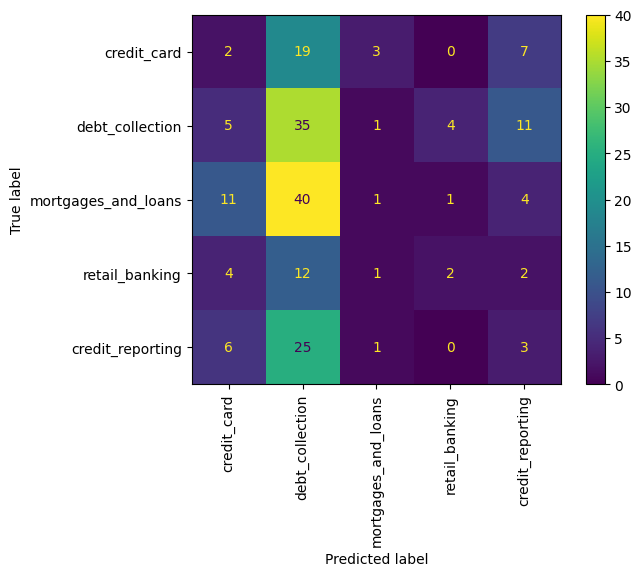

In [32]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test[:max_examples], y_pred_zs)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['credit_card', 'debt_collection','mortgages_and_loans','retail_banking', 'credit_reporting'])

cm_display.plot(xticks_rotation='vertical')
plt.show()


### Using Prompt Tuning with Learning Rate = 0.3

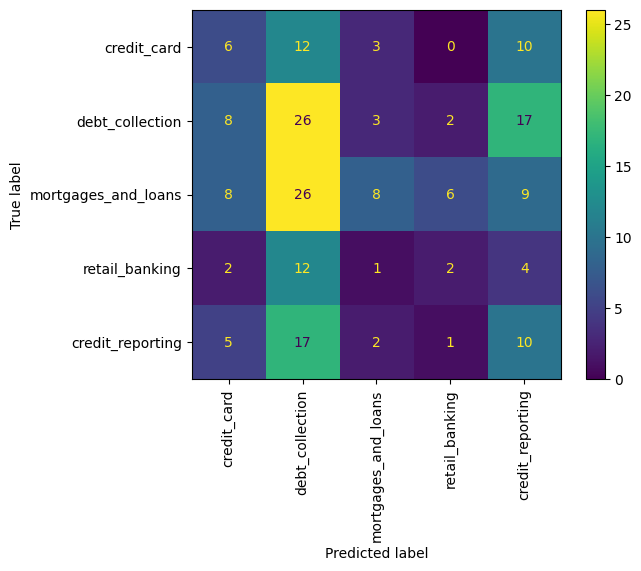

In [33]:

confusion_matrix = metrics.confusion_matrix(y_test[:max_examples], y_pred_pt_03)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['credit_card', 'debt_collection','mortgages_and_loans','retail_banking', 'credit_reporting'])

cm_display.plot(xticks_rotation='vertical')
plt.show()
